<a href="https://colab.research.google.com/github/lorenzopalaia/Progetto-Lab-IA/blob/main/GC_csv_pt_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification via .csv features

Con questo approccio andremo a classificare i generi musicali sfruttando le features presenti nei file `.csv` del dataset. Questi contengono features quali:
* media e varianza di
  * ampiezze di banda spettrale
  * armoniche
  * chroma features
  * ...
* BPM
* ...

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random

import librosa, IPython
import librosa.display as lplt

import keras as k
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

## Carichiamo il dataset

In [ ]:
df = pd.read_csv('GTZAN Dataset/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


Codifichiamo le label dei generi

In [ ]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


## Visualizziamo i dati

### Chroma Features

Le **Chroma Features** sono strettamente correlate alle diverse classi di altezza di un tono. Le Chroma Features sono un potente strumento per analizzare la musica le cui altezze possono essere classificate in modo significativo (spesso in dodici categorie) e la cui accordatura si avvicina alla scala equanime. Una delle proprietà principali delle Chroma Features è che catturano le caratteristiche armoniche e melodiche della musica e allo stesso tempo si rivelano robuste ai cambiamenti di timbro e strumentazione

In [ ]:
audio_fp = 'GTZAN Dataset/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

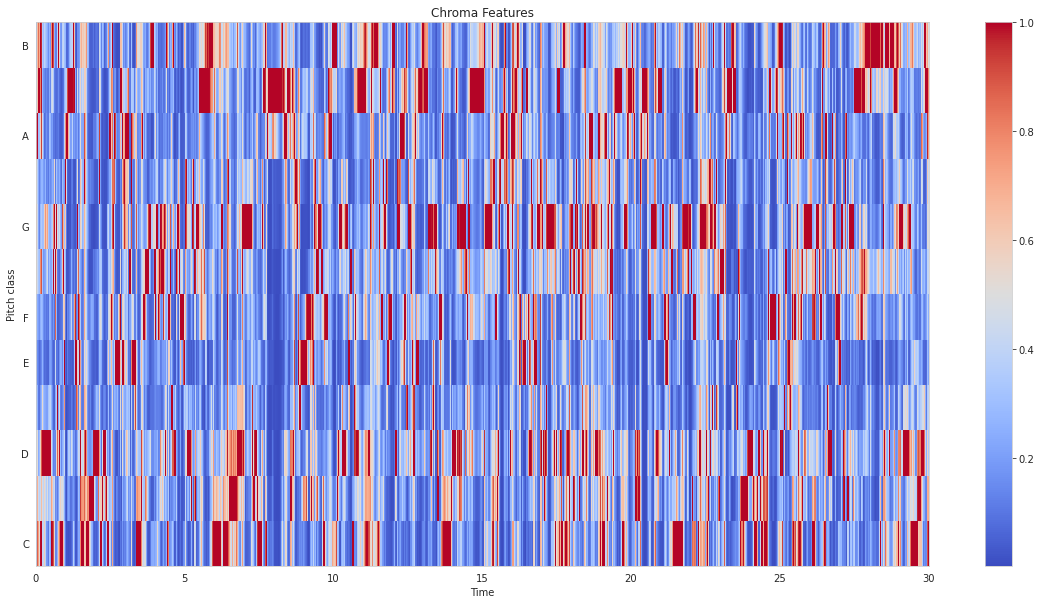

In [ ]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(20, 10))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

### Correlation Heatmap

Heatmap che mostra la correlazione tra le variabili che nel dataset sono indicate come *mean*. Queste sono, appunto, delle medie calcolate tra le varie features

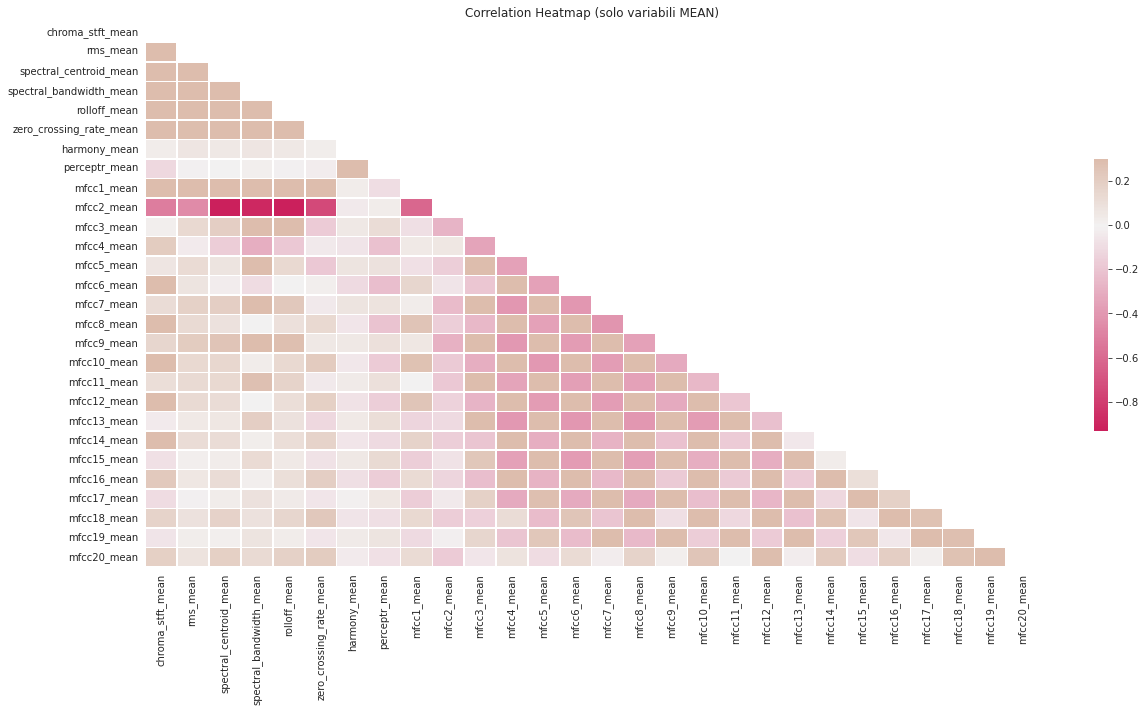

In [ ]:
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 10));

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (solo variabili MEAN)')
plt.show()

### BPM Boxplot

Per ogni genere identifichiamo un rettangolo ed un segmento. Considerando l'insieme dei valori dei BPM di ogni traccia oer genere, il rettangolo è delimitato dal primo e dal terzo quartile dell'insieme, $q_{1/4}$ e $q_{3/4}$, e diviso al suo interno dalla mediana, $q_{1/2}$. I segmenti sono delimitati dal minimo e dal massimo dell'insieme. In questo modo vengono rappresentati graficamente i quattro intervalli ugualmente popolati delimitati dai quartili. 

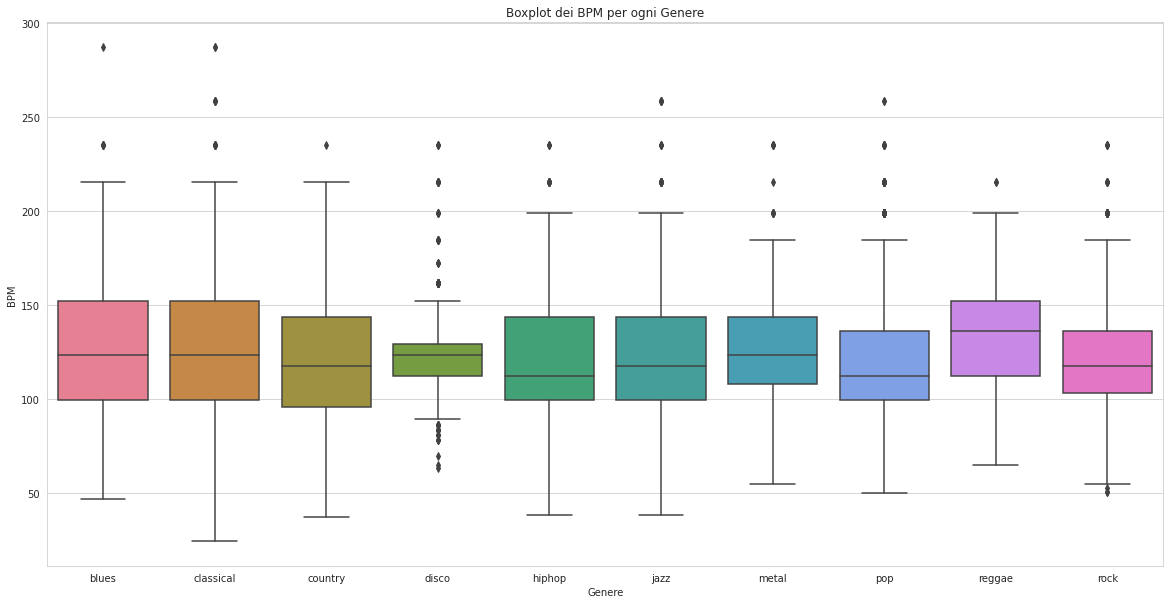

In [ ]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(20, 10));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('Boxplot dei BPM per ogni Genere')
plt.xlabel("Genere")
plt.ylabel("BPM")
plt.show()

## Prepariamo i dati

In [ ]:
df.label = [label_index[l] for l in df.label]
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

Rimuoviamo le colonne irrilevanti

In [ ]:
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

Dividiamo il dataset in tre set, uno di addestramento, uno di validazione e uno di test

In [ ]:
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

Normalizziamo le features: cenriamo e scaliamo rimuovendo la media e portando la varianza a 1

In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

## Tensorflow

### Costruzione dei modelli

#### Modello 1

In [ ]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])

#### Modello 2

In [ ]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax'),
])

#### Modello 3

In [ ]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),   
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax'),
])

#### Modello 4

In [ ]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(10, activation='softmax'),
])

### Funzioni

In [ ]:
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size)

In [ ]:
def plotHistory(history):
    print("Max. Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

### Training

Epoch 1/70
55/55 [==============================] - 3s 7ms/step - loss: 1.4352 - accuracy: 0.5028 - val_loss: 1.0395 - val_accuracy: 0.6491
Epoch 2/70
55/55 [==============================] - 0s 5ms/step - loss: 0.8626 - accuracy: 0.7079 - val_loss: 0.7929 - val_accuracy: 0.7361
Epoch 3/70
55/55 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.7775 - val_loss: 0.6759 - val_accuracy: 0.7760
Epoch 4/70
55/55 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.8205 - val_loss: 0.6389 - val_accuracy: 0.7786
Epoch 5/70
55/55 [==============================] - 0s 4ms/step - loss: 0.4726 - accuracy: 0.8498 - val_loss: 0.5797 - val_accuracy: 0.7973
Epoch 6/70
55/55 [==============================] - 0s 5ms/step - loss: 0.4007 - accuracy: 0.8726 - val_loss: 0.5293 - val_accuracy: 0.8109
Epoch 7/70
55/55 [==============================] - 0s 5ms/step - loss: 0.3377 - accuracy: 0.8965 - val_loss: 0.5029 - val_accuracy: 0.8220
Epoch 8/70
55/55 [==

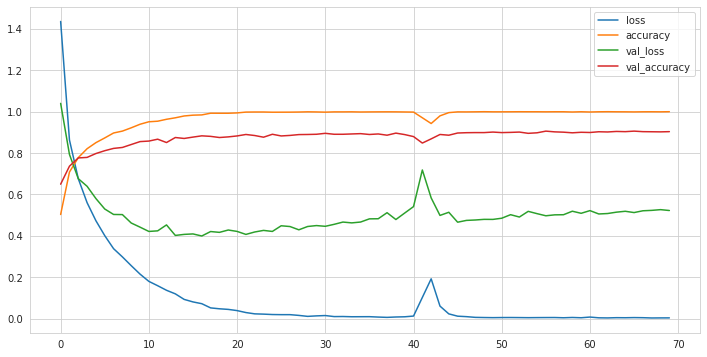

In [ ]:
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')
model_1.save("models/tf/GC_csv/model_1")
plotHistory(model_1_history)

Epoch 1/100
55/55 [==============================] - 1s 7ms/step - loss: 1.6627 - accuracy: 0.4023 - val_loss: 1.1369 - val_accuracy: 0.5915
Epoch 2/100
55/55 [==============================] - 0s 5ms/step - loss: 1.1490 - accuracy: 0.6042 - val_loss: 0.8895 - val_accuracy: 0.6850
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 0.9072 - accuracy: 0.6881 - val_loss: 0.7383 - val_accuracy: 0.7442
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 0.7715 - accuracy: 0.7427 - val_loss: 0.6706 - val_accuracy: 0.7760
Epoch 5/100
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.7723 - val_loss: 0.6237 - val_accuracy: 0.7776
Epoch 6/100
55/55 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.7915 - val_loss: 0.5549 - val_accuracy: 0.8165
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5596 - accuracy: 0.8105 - val_loss: 0.5068 - val_accuracy: 0.8286
Epoch 8/100
5

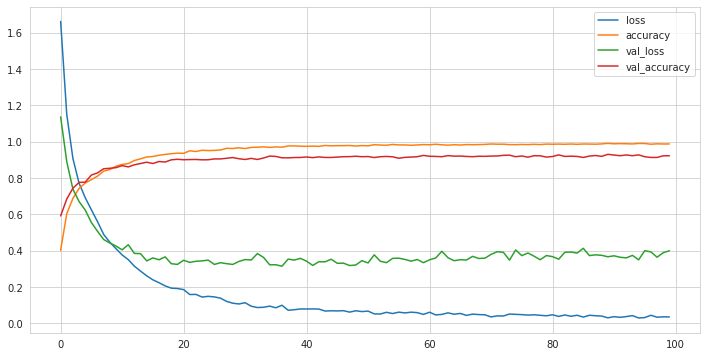

In [ ]:
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')
model_2.save("models/tf/GC_csv/model_2")
plotHistory(model_2_history)

Epoch 1/700
55/55 [==============================] - 1s 7ms/step - loss: 2.2856 - accuracy: 0.1363 - val_loss: 2.2041 - val_accuracy: 0.2826
Epoch 2/700
55/55 [==============================] - 0s 4ms/step - loss: 2.2028 - accuracy: 0.2026 - val_loss: 2.1011 - val_accuracy: 0.3589
Epoch 3/700
55/55 [==============================] - 0s 4ms/step - loss: 2.1015 - accuracy: 0.2807 - val_loss: 1.9693 - val_accuracy: 0.3584
Epoch 4/700
55/55 [==============================] - 0s 4ms/step - loss: 1.9831 - accuracy: 0.3165 - val_loss: 1.8317 - val_accuracy: 0.3600
Epoch 5/700
55/55 [==============================] - 0s 4ms/step - loss: 1.8687 - accuracy: 0.3363 - val_loss: 1.7155 - val_accuracy: 0.3736
Epoch 6/700
55/55 [==============================] - 0s 4ms/step - loss: 1.7776 - accuracy: 0.3655 - val_loss: 1.6236 - val_accuracy: 0.4029
Epoch 7/700
55/55 [==============================] - 0s 4ms/step - loss: 1.7121 - accuracy: 0.3791 - val_loss: 1.5466 - val_accuracy: 0.4333
Epoch 8/700
5

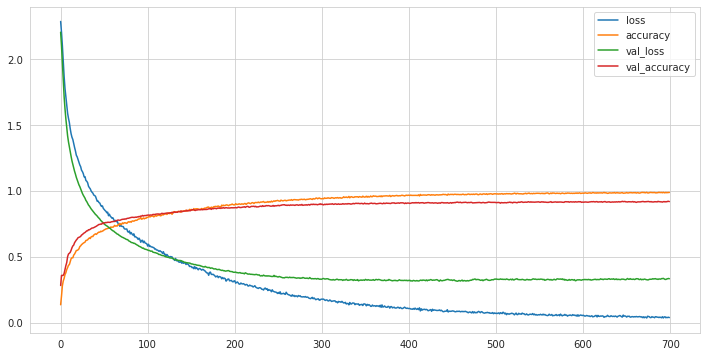

In [ ]:
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')
model_3.save("models/tf/GC_csv/model_3")
plotHistory(model_3_history)

Epoch 1/500
55/55 [==============================] - 2s 8ms/step - loss: 1.7405 - accuracy: 0.3752 - val_loss: 1.2159 - val_accuracy: 0.5622
Epoch 2/500
55/55 [==============================] - 0s 5ms/step - loss: 1.2856 - accuracy: 0.5578 - val_loss: 1.0158 - val_accuracy: 0.6456
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 1.0758 - accuracy: 0.6452 - val_loss: 0.8469 - val_accuracy: 0.7174
Epoch 4/500
55/55 [==============================] - 0s 5ms/step - loss: 0.9141 - accuracy: 0.7011 - val_loss: 0.7492 - val_accuracy: 0.7467
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 0.8124 - accuracy: 0.7397 - val_loss: 0.6699 - val_accuracy: 0.7755
Epoch 6/500
55/55 [==============================] - 0s 5ms/step - loss: 0.7208 - accuracy: 0.7722 - val_loss: 0.6106 - val_accuracy: 0.7942
Epoch 7/500
55/55 [==============================] - 0s 5ms/step - loss: 0.6459 - accuracy: 0.7926 - val_loss: 0.6824 - val_accuracy: 0.7821
Epoch 8/500
5

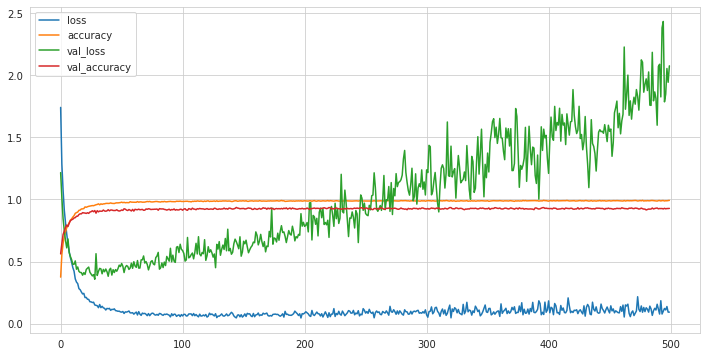

In [ ]:
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')
model_4.save("models/tf/GC_csv/model_4")
plotHistory(model_4_history)

### Testing

Il **Modello 4** si è rivelato quello con la Validation Accuracy più alta. Valutiamo ora il modello sul dataset di test

In [ ]:
model_4 = tf.keras.models.load_model("models/tf/GC_csv/model_4")
model_4.summary()

test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size = 128)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 1024)              59392     
                                                                 
 dropout_21 (Dropout)        (None, 1024)              0         
                                                                 
 dense_39 (Dense)            (None, 512)               524800    
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 256)               131328    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)              

## PyTorch

### Costruzione dei modelli

#### Modello 1

In [ ]:
class Model1(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 64)
    self.linear4 = nn.Linear(64, 10)

  def forward(self, X_train):
    out = F.relu(self.linear1(X_train))
    out = F.relu(self.linear2(out))
    out = F.relu(self.linear3(out))
    out = F.softmax(self.linear4(out))
    return out

#### Modello 2

In [ ]:
class Model2(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 128)
    self.linear4 = nn.Linear(128, 64)
    self.linear5 = nn.Linear(64, 10)

  def forward(self, X_train):
    out = F.relu(self.linear1(X_train))
    out = F.dropout(out, 0.2)
    out = F.relu(self.linear2(out))
    out = F.dropout(out, 0.2)
    out = F.relu(self.linear3(out))
    out = F.dropout(out, 0.2)
    out = F.relu(self.linear4(out))
    out = F.dropout(out, 0.2)
    out = F.softmax(self.linear5(out))
    return out

#### Modello 3

In [ ]:
class Model3(Model2):
  def __init__(self, input_shape):
    super().__init__(input_shape)

#### Modello 4

In [ ]:
class Model4(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 256)
    self.linear4 = nn.Linear(256, 128)
    self.linear5 = nn.Linear(128, 64)
    self.linear6 = nn.Linear(64, 10)

  def forward(self, X_train):
    out = F.relu(self.linear1(X_train))
    out = F.dropout(out, 0.3)
    out = F.relu(self.linear2(out))
    out = F.dropout(out, 0.3)
    out = F.relu(self.linear3(out))
    out = F.dropout(out, 0.3)
    out = F.relu(self.linear4(out))
    out = F.dropout(out, 0.3)
    out = F.relu(self.linear5(out))
    out = F.dropout(out, 0.3)
    out = F.softmax(self.linear6(out))
    return out

### Costruzione del dataset PyTorch

In [ ]:
class GCDataset(torch.utils.data.Dataset):
  def __init__(self, X_df, y_df):
    self.X_df = torch.tensor(X_df.values, dtype=torch.float32)
    self.y_df = torch.tensor(y_df.values, dtype=torch.float32).type(torch.LongTensor)
 
  def __len__(self):
    return len(self.X_df)
   
  def __getitem__(self, idx):
    return self.X_df[idx], self.y_df[idx]

In [ ]:
trainset = GCDataset(X_train, y_train)
devset = GCDataset(X_dev, y_dev)
testset = GCDataset(X_test, y_dev)

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True, num_workers = 2)
dev_loader = torch.utils.data.DataLoader(devset, batch_size = 128, shuffle = False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = False, num_workers = 2)

### Funzioni

In [ ]:
criterion = nn.CrossEntropyLoss()

def trainModel(model, epochs, optimizer):
  train_losses = []
  dev_losses = []
  train_acc = []
  dev_acc = []
  for e in range(epochs):
    train_loss = 0.0
    train_correct = 0
    for i, train_data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        train_inputs, train_labels = train_data
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_inputs)
        # Find the Loss
        loss = criterion(train_outputs, train_labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        # Calculate correct
        _, predicted = torch.max(train_outputs, 1)
        train_correct += (predicted == train_labels).float().sum()
     
    dev_loss = 0.0
    dev_correct = 0
    model.eval()     # Optional when not using Model Specific layer
    for i, dev_data in enumerate(dev_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        dev_inputs, dev_labels = dev_data
        # Forward Pass
        dev_outputs = model(dev_inputs)
        # Find the Loss
        loss = criterion(dev_outputs, dev_labels)
        # Calculate Loss
        dev_loss += loss.item()
        # Calculate correct
        _, predicted = torch.max(dev_outputs, 1)
        dev_correct += (predicted == dev_labels).float().sum()

    train_accuracy = train_correct / len(trainset)
    dev_accuracy = dev_correct / len(trainset)

    train_losses.append(train_loss / len(train_loader))
    dev_losses.append(dev_loss / len(dev_loader))

    train_acc.append(train_accuracy)
    dev_acc.append(dev_accuracy)
 
    print(f'Epoch {e+1}/{epochs \
      }\tTr. Loss: {train_loss / len(train_loader) \
      }\tTr. Acc.: {train_accuracy \
      }\tVal. Loss: {dev_loss / len(dev_loader) \
      }\tVal Acc.: {dev_accuracy}')

  plt.plot(train_losses, label = "Train Loss")
  plt.plot(dev_losses, label = "Dev Loss")
  plt.plot(train_acc, label = "Train Accuracy")
  plt.plot(dev_acc, label = "Dev Accuracy")
  plt.legend()
  plt.show()

In [ ]:
def evaluateModel(model):
  dataiter = iter(test_loader)
  data, labels = dataiter.next()
  outputs = model(data)
  _, predicted = torch.max(outputs, 1)
  corrects = 0
  for e in range(len(labels)):
    correctness = labels[e].item() == predicted[e].item()
    if correctness:
      corrects += 1
    print("Label:", index_label[labels[e].item()], "Predicted:", index_label[predicted[e].item()], "Correct:", correctness)
  print(f"Accuracy: {corrects}/128, {100 * corrects/128}%")

### Training

Epoch 1/70	Tr. Loss: 2.1503792957826096	Tr. Acc.: 0.34348633885383606	Val. Loss: 1.9981110319495201	Val Acc.: 0.13513512909412384
Epoch 2/70	Tr. Loss: 1.9315700899470936	Tr. Acc.: 0.5426855683326721	Val. Loss: 1.8850960433483124	Val Acc.: 0.16645216941833496
Epoch 3/70	Tr. Loss: 1.844392518563704	Tr. Acc.: 0.6286286115646362	Val. Loss: 1.8350005000829697	Val Acc.: 0.1814671754837036
Epoch 4/70	Tr. Loss: 1.7904564597389914	Tr. Acc.: 0.6878306865692139	Val. Loss: 1.7964236736297607	Val Acc.: 0.19376519322395325
Epoch 5/70	Tr. Loss: 1.7567208376797763	Tr. Acc.: 0.7205777168273926	Val. Loss: 1.764798328280449	Val Acc.: 0.2012012004852295
Epoch 6/70	Tr. Loss: 1.724382951042869	Tr. Acc.: 0.7498927712440491	Val. Loss: 1.7479764223098755	Val Acc.: 0.20506221055984497
Epoch 7/70	Tr. Loss: 1.6989096359773115	Tr. Acc.: 0.7744887471199036	Val. Loss: 1.7387582808732986	Val Acc.: 0.20663520693778992
Epoch 8/70	Tr. Loss: 1.6877830310301347	Tr. Acc.: 0.7847847938537598	Val. Loss: 1.733740009367466	Val

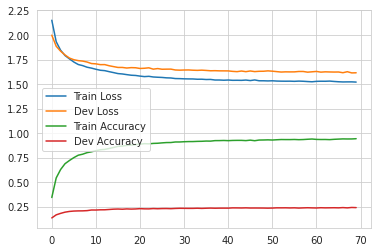

In [ ]:
model1 = Model1(X_train.shape[1])
trainModel(model1, 70, torch.optim.Adam(model1.parameters(), eps=1e-7))
torch.save(model1.state_dict(), 'models/pt/GC_csv/model_1.pth')

Epoch 1/100	Tr. Loss: 2.14827195297588	Tr. Acc.: 0.323037326335907	Val. Loss: 2.0312187150120735	Val Acc.: 0.12569712102413177
Epoch 2/100	Tr. Loss: 1.9629549958489159	Tr. Acc.: 0.5007864832878113	Val. Loss: 1.934467799961567	Val Acc.: 0.15072214603424072
Epoch 3/100	Tr. Loss: 1.8958656766197899	Tr. Acc.: 0.5658515691757202	Val. Loss: 1.8826949372887611	Val Acc.: 0.16416417062282562
Epoch 4/100	Tr. Loss: 1.8348609989339655	Tr. Acc.: 0.6326326131820679	Val. Loss: 1.8417725637555122	Val Acc.: 0.17474617063999176
Epoch 5/100	Tr. Loss: 1.7936100222847677	Tr. Acc.: 0.6733876466751099	Val. Loss: 1.8080031275749207	Val Acc.: 0.18447019159793854
Epoch 6/100	Tr. Loss: 1.7758715933019464	Tr. Acc.: 0.6862576603889465	Val. Loss: 1.7852710112929344	Val Acc.: 0.19262118637561798
Epoch 7/100	Tr. Loss: 1.7487613634629684	Tr. Acc.: 0.7164307236671448	Val. Loss: 1.769527830183506	Val Acc.: 0.1970541924238205
Epoch 8/100	Tr. Loss: 1.7328974853862416	Tr. Acc.: 0.7317317128181458	Val. Loss: 1.7755267396569

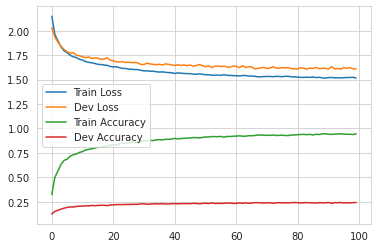

In [ ]:
model2 = Model2(X_train.shape[1])
trainModel(model2, 100, torch.optim.Adam(model2.parameters(), eps=1e-7))
torch.save(model2.state_dict(), 'models/pt/GC_csv/model_2.pth')

Epoch 1/700	Tr. Loss: 2.3026670542630283	Tr. Acc.: 0.10610610246658325	Val. Loss: 2.3027056604623795	Val Acc.: 0.02774202823638916
Epoch 2/700	Tr. Loss: 2.3026223572817717	Tr. Acc.: 0.11297011375427246	Val. Loss: 2.302718937397003	Val Acc.: 0.028600027784705162
Epoch 3/700	Tr. Loss: 2.302559063651345	Tr. Acc.: 0.10739310830831528	Val. Loss: 2.302607700228691	Val Acc.: 0.030030030757188797
Epoch 4/700	Tr. Loss: 2.302578202160922	Tr. Acc.: 0.10624910891056061	Val. Loss: 2.3026583194732666	Val Acc.: 0.030030030757188797
Epoch 5/700	Tr. Loss: 2.302564694664695	Tr. Acc.: 0.10439010709524155	Val. Loss: 2.302557125687599	Val Acc.: 0.03203203156590462
Epoch 6/700	Tr. Loss: 2.3025511741638183	Tr. Acc.: 0.10810811072587967	Val. Loss: 2.302608475089073	Val Acc.: 0.02874302864074707
Epoch 7/700	Tr. Loss: 2.3025121515447444	Tr. Acc.: 0.1128271147608757	Val. Loss: 2.3025829046964645	Val Acc.: 0.02988702990114689
Epoch 8/700	Tr. Loss: 2.302507409182462	Tr. Acc.: 0.1069641038775444	Val. Loss: 2.302602

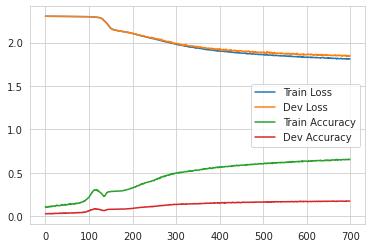

In [ ]:
model3 = Model3(X_train.shape[1])
trainModel(model3, 700, torch.optim.SGD(model3.parameters(), 0.01, 0.0))
torch.save(model3.state_dict(), 'models/pt/GC_csv/model_3.pth')

Epoch 1/500	Tr. Loss: 2.361016798019409	Tr. Acc.: 0.0993850976228714	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 2/500	Tr. Loss: 2.3616136117414994	Tr. Acc.: 0.09995710104703903	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 3/500	Tr. Loss: 2.3612839135256682	Tr. Acc.: 0.09995710104703903	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 4/500	Tr. Loss: 2.3612839178605514	Tr. Acc.: 0.09995710104703903	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 5/500	Tr. Loss: 2.3609542413191362	Tr. Acc.: 0.09995710104703903	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 6/500	Tr. Loss: 2.3614487474614925	Tr. Acc.: 0.09995710104703903	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 7/500	Tr. Loss: 2.361201459711248	Tr. Acc.: 0.09995710104703903	Val. Loss: 2.3597564846277237	Val Acc.: 0.028314027935266495
Epoch 8/500	Tr. Loss: 2.361366297981956	Tr. Acc.: 0.09995710104703903	Val. Loss

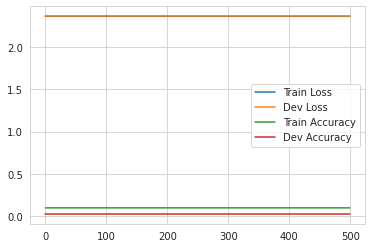

In [ ]:
model4 = Model4(X_train.shape[1])
trainModel(model4, 500, torch.optim.RMSprop(model4.parameters()))
torch.save(model4.state_dict(), 'models/pt/GC_csv/model_4.pth')

### Testing

In [ ]:
model1 = Model1(X_train.shape[1])
model1.load_state_dict(torch.load("models/pt/GC_csv/model_1.pth"))
model1.eval()
evaluateModel(model1)

Label: pop Predicted: metal Correct: False
Label: classical Predicted: country Correct: False
Label: blues Predicted: classical Correct: False
Label: hiphop Predicted: classical Correct: False
Label: metal Predicted: metal Correct: True
Label: classical Predicted: jazz Correct: False
Label: pop Predicted: classical Correct: False
Label: country Predicted: pop Correct: False
Label: country Predicted: hiphop Correct: False
Label: blues Predicted: jazz Correct: False
Label: classical Predicted: rock Correct: False
Label: metal Predicted: blues Correct: False
Label: blues Predicted: pop Correct: False
Label: disco Predicted: jazz Correct: False
Label: metal Predicted: jazz Correct: False
Label: hiphop Predicted: pop Correct: False
Label: jazz Predicted: metal Correct: False
Label: reggae Predicted: hiphop Correct: False
Label: metal Predicted: metal Correct: True
Label: reggae Predicted: disco Correct: False
Label: hiphop Predicted: metal Correct: False
Label: country Predicted: metal Corr

In [ ]:
model2 = Model2(X_train.shape[1])
model2.load_state_dict(torch.load("models/pt/GC_csv/model_2.pth"))
model2.eval()
evaluateModel(model2)

Label: pop Predicted: metal Correct: False
Label: classical Predicted: classical Correct: True
Label: blues Predicted: classical Correct: False
Label: hiphop Predicted: classical Correct: False
Label: metal Predicted: metal Correct: True
Label: classical Predicted: jazz Correct: False
Label: pop Predicted: classical Correct: False
Label: country Predicted: pop Correct: False
Label: country Predicted: hiphop Correct: False
Label: blues Predicted: jazz Correct: False
Label: classical Predicted: metal Correct: False
Label: metal Predicted: country Correct: False
Label: blues Predicted: pop Correct: False
Label: disco Predicted: jazz Correct: False
Label: metal Predicted: classical Correct: False
Label: hiphop Predicted: pop Correct: False
Label: jazz Predicted: metal Correct: False
Label: reggae Predicted: hiphop Correct: False
Label: metal Predicted: metal Correct: True
Label: reggae Predicted: disco Correct: False
Label: hiphop Predicted: metal Correct: False
Label: country Predicted: m

In [ ]:
model3 = Model3(X_train.shape[1])
model3.load_state_dict(torch.load("models/pt/GC_csv/model_3.pth"))
model3.eval()
evaluateModel(model3)

Label: pop Predicted: metal Correct: False
Label: classical Predicted: classical Correct: True
Label: blues Predicted: classical Correct: False
Label: hiphop Predicted: classical Correct: False
Label: metal Predicted: metal Correct: True
Label: classical Predicted: jazz Correct: False
Label: pop Predicted: classical Correct: False
Label: country Predicted: pop Correct: False
Label: country Predicted: hiphop Correct: False
Label: blues Predicted: jazz Correct: False
Label: classical Predicted: metal Correct: False
Label: metal Predicted: country Correct: False
Label: blues Predicted: hiphop Correct: False
Label: disco Predicted: jazz Correct: False
Label: metal Predicted: classical Correct: False
Label: hiphop Predicted: pop Correct: False
Label: jazz Predicted: metal Correct: False
Label: reggae Predicted: hiphop Correct: False
Label: metal Predicted: metal Correct: True
Label: reggae Predicted: reggae Correct: True
Label: hiphop Predicted: rock Correct: False
Label: country Predicted:

In [ ]:
model4 = Model4(X_train.shape[1])
model4.load_state_dict(torch.load("models/pt/GC_csv/model_4.pth"))
model4.eval()
evaluateModel(model4)

Label: pop Predicted: classical Correct: False
Label: classical Predicted: classical Correct: True
Label: blues Predicted: classical Correct: False
Label: hiphop Predicted: classical Correct: False
Label: metal Predicted: classical Correct: False
Label: classical Predicted: classical Correct: True
Label: pop Predicted: classical Correct: False
Label: country Predicted: classical Correct: False
Label: country Predicted: classical Correct: False
Label: blues Predicted: classical Correct: False
Label: classical Predicted: classical Correct: True
Label: metal Predicted: classical Correct: False
Label: blues Predicted: classical Correct: False
Label: disco Predicted: classical Correct: False
Label: metal Predicted: classical Correct: False
Label: hiphop Predicted: classical Correct: False
Label: jazz Predicted: classical Correct: False
Label: reggae Predicted: classical Correct: False
Label: metal Predicted: classical Correct: False
Label: reggae Predicted: classical Correct: False
Label: h